# Part 1. Text wrangling
App to analyze web-site search logs (internal search)<br>
**This script:** Resolve text formatting/syntax problems and match against historical file<br>
Authors: dan.wendling@nih.gov, <br>
Last modified: 2018-09-09


## Script contents

1. Start-up / What to put into place, where
2. Unite search log data in single dataframe; globally update columns and rows
3. Separate out the queries with non-English characters
4. Run baseline dataset stats
5. Clean up content to improve matching
6. Make special-case assignments with F&R, RegEx: Bibliographic, Numeric, Named entities
7. Create logAfterGoldStandard - Match to the "gold standard" file of historical matches
8. Create 'uniques' dataframe/file for APIs


## FIXMEs

Things Dan wrote for Dan; modify as needed. There are more FIXMEs in context.
* [ ] Update from 1:1 capture to 1:n capture
* [ ] Add two more runs against the UMLS Metathesaurus API:
    - Isolate non-English terms and remove them from percent-complete calcs.
      Add separate statistics for non-English terms.
    - Run remaining terms with "word" matching or "approximate: matching;
      compare those suggestions to ML suggestions. Create a df with one 
      column for each suggestion source, Metathesaurus-Approximate, 
      LinearSVC, LogisticRegresssion...
* [ ] Add summary visualizations / data quality dashboard
* [ ] Update Cognos search log reports:
** [ ] Change col names to one word: 'Search Timestamp': 'Timestamp', 
  'NLM IP Y/N':'StaffYN', 'IP':'SessionID'
** [ ] Make it UTF-8-enough for Python 
** [ ] Remove 8 col of blank cells
** [ ] Standardize Timestamp syntax b/w CSV and Excel formats
** [ ] I could isolate acronyms easier if queries with unaltered case were 
  available. I can lower-case things as needed. Reasons for receiving in lc? 
  Any reasons to keep it the way it is?
* [ ] Continue changing processing order. Perhaps avoid all the extra Semantic
Network assignments until very end of scripts 1 and 2.


## Cheat sheets for markdown text

* https://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/Working%20With%20Markdown%20Cells.html
* https://medium.com/ibm-data-science-experience/markdown-for-jupyter-notebooks-cheatsheet-386c05aeebed
* https://www.dataquest.io/blog/jupyter-notebook-tips-tricks-shortcuts/


## 1. Start-up / What to put into place, where

Search log from internal site search. This script assumes an Excel file,
 top two rows need to be ignored, and these columns:

| ID | IP | NLM IP Y/N | Referrer | Query | Search Timestamp |

ID               - Unique row ID
IP               - Unique session ID; anonomized session ID
NLM IP Y/N       - Whether the query was from the NLM LAN, Y or N
Referrer         - Where the visitor was when the search was submitted
Query            - The query content
Search Timestamp - When the query was run

Required for this script: Referrer, Query, Search Timestamp. I use Excel 
because my source info system breaks CSV files when the query has commas.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import pie, axis, show
import numpy as np
import os
import string

# Set working directory
os.chdir('/Users/wendlingd/_webDS')

localDir = '01_Text_wrangling_files/'

'''
Before running script, copy the following new files to /00 SourceFiles/; 
adjust names below, as needed. Make them THE SAME TIME PERIOD - one month,
one quarter, one year, whatever.
'''

# What is your new log file named?
newSearchLogFile = '00_Source_files/week31.xlsx'

# Bring in historical file of (somewhat edited) matches
GoldStandard = localDir + 'GoldStandard_Master.xlsx'
GoldStandard = pd.read_excel(GoldStandard)

'''
SemanticNetworkReference - Used in progress charts

It's a customized version of the list at 
https://www.nlm.nih.gov/research/umls/META3_current_semantic_types.html, 
to be used to put search terms into huge bins. Can be integrated into 
GoldStandard and be available if we want to see the progress of assignments
through the process.
'''
SemanticNetworkReference = localDir + 'SemanticNetworkReference.xlsx'


## 2. Unite search log data into single dataframe; globally update columns and rows

If csv and Tab delimited, for example: pd.read_csv(filename, sep='\t')
searchLog = pd.read_csv(newSearchLogFile)

In [2]:
# Search log from Excel; IBM Cognos starts a new worksheet every 65k rows;
# open the file to see how many worksheets you need to bring in. FY18 q3 had 6 worksheets
searchLog = pd.read_excel(newSearchLogFile, skiprows=2)
'''
x2 = pd.read_excel(newSearchLogFile, 'Page1_2', skiprows=2)
x3 = pd.read_excel(newSearchLogFile, 'Page1_3', skiprows=2)
x4 = pd.read_excel(newSearchLogFile, 'Page1_4', skiprows=2)
x5 = pd.read_excel(newSearchLogFile, 'Page1_5', skiprows=2)
x6 = pd.read_excel(newSearchLogFile, 'Page1_6', skiprows=2)
# x5 = pd.read_excel('00 SourceFiles/2018-06/Queries-2018-05.xlsx', 'Page1_2', skiprows=2)

searchLog = pd.concat([x1, x2, x3, x4, x5, x6], ignore_index=True) # , x3, x4, x5, x6, x7
'''

searchLog.head(n=5)
searchLog.shape
searchLog.info()
searchLog.columns

# Drop ID column, not needed
searchLog.drop(['ID'], axis=1, inplace=True)
            
# Until Cognos report is fixed, problem of blank columns, multi-word col name
# Update col name
searchLog = searchLog.rename(columns={'Search Timestamp': 'Timestamp', 
                                      'NLM IP Y/N':'StaffYN',
                                      'IP':'SessionID'})

# Remove https:// to become joinable with traffic data
searchLog['Referrer'] = searchLog['Referrer'].str.replace('https://', '')

# Dupe off the Query column into a lower-cased 'adjustedQueryCase', which 
# will be the column you match against
searchLog['adjustedQueryCase'] = searchLog['Query'].str.lower()

# Remove incomplete rows, which can cause errors later
searchLog = searchLog[~pd.isnull(searchLog['Referrer'])]
searchLog = searchLog[~pd.isnull(searchLog['Query'])]
searchLog.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20639 entries, 0 to 20638
Data columns (total 6 columns):
ID                  20639 non-null object
IP                  20638 non-null object
NLM IP Y/N          20639 non-null object
Referrer            20638 non-null object
Query               20639 non-null object
Search Timestamp    20638 non-null datetime64[ns]
dtypes: datetime64[ns](1), object(5)
memory usage: 967.5+ KB


,SessionID,StaffYN,Referrer,Query,Timestamp,adjustedQueryCase
0,FCB8C84AEDB5855CDDB2F29E38C8C8D1,N,www.nlm.nih.gov/,lichen ruber mucosae,2018-07-30 07:48:01.000,lichen ruber mucosae
1,D052BA917FD4489BD63014BE6568670E,N,www.nlm.nih.gov/,molecular identification of marine bacteria,2018-07-30 01:14:26.000,molecular identification of marine bacteria
2,D052BA917FD4489BD63014BE6568670E,N,vsearch.nlm.nih.gov/vivisimo/cgi-bin/query-met...,molecular identification of marine fishes bact...,2018-07-30 01:23:06.000,molecular identification of marine fishes bact...
3,47C9DEE89B48E22FB53E2BE2DB107763,N,www.nlm.nih.gov/bsd/serfile_addedinfo.html,secondaries brain prognostic factors,2018-07-30 02:18:34.999,secondaries brain prognostic factors
4,993C3E958AB335FC500CB6BA0C03CBD8,N,vsearch.nlm.nih.gov/vivisimo/cgi-bin/query-met...,smoking&alzheimer's disease,2018-07-30 02:26:16.999,smoking&alzheimer's disease


In [4]:
# *** STILL NEEDED?? - COMMENTED OUT TO AVOID DAMAGING IN AUTO-RUN ***
# Eyeball df and remove (some) foreign-language entries APIs can't match - non-Roman's (??)

'''
showForeign = searchLog.sort_values(by='adjustedQueryCase', ascending=False)
showForeign = showForeign.reset_index()
showForeign.drop(['index'], axis=1, inplace=True)

nonForeign = showForeign[330:] # Eyeball, update to remove down to the rows the APIs will be able to parse

# Eyeball, sorting by adjustedQueryCase, remove specific useless rows as needed
nonForeign.drop(41402, inplace=True)
nonForeign.drop(41401, inplace=True)
nonForeign.drop(19657, inplace=True)
nonForeign.drop(19656, inplace=True)
nonForeign.drop(19655, inplace=True)
nonForeign.drop(19654, inplace=True)
nonForeign.drop(19646, inplace=True)
nonForeign.drop(19647, inplace=True)

# Space clean-up as needed
nonForeign['adjustedQueryCase'] = nonForeign['adjustedQueryCase'].str.replace('  ', ' ') # two spaces to one
nonForeign['adjustedQueryCase'] = nonForeign['adjustedQueryCase'].str.strip() # remove leading and trailing spaces
nonForeign = nonForeign.loc[(nonForeign['adjustedQueryCase'] != "")]
'''

'''
# Start new df so you can revert if needed
searchLogClean = nonForeign

# Remove showForeign, nonForeign, searchLog
'''


"\n# Start new df so you can revert if needed\nsearchLogClean = nonForeign\n\n\n\n# When restarting work or recovering from error later, use cleaned log from file\n# newSearchLogFile = '00 SourceFiles/2018-04/q2_2018-en-us.xlsx'\n# searchLogClean = pd.read_excel(localDir + 'searchLogClean.xlsx')\n\n# Remove showForeign, nonForeign, searchLog\n"

In [ ]:
# When restarting work or recovering from error later, use cleaned log from file
# newSearchLogFile = '00 SourceFiles/2018-04/q2_2018-en-us.xlsx'
# searchLogClean = pd.read_excel(localDir + 'searchLogClean.xlsx')

## 4. Run baseline dataset stats

Not the purpose of this project, but other staff have use for... Before we
cut down the log content, some quick calcuations.

Future: Overall percentage of hit-and-runs, 'one and done'
Group and count by IP address - Create table of counts

numberOfSearches = searchLog
numberOfSearches.groupby(['ID']).size()
numberOfSearches = numberOfSearches.reset_index()


In [3]:
print("Total searches in raw log file: {}".format(len(searchLog)))

# tot
print("Total SEARCHES, on NLM LAN or not\n{}".format(searchLog['StaffYN'].value_counts()))

print("Total SESSIONS, on NLM LAN or not\n{}".format(searchLog.groupby('StaffYN')['SessionID'].nunique()))

# If you see digits in text col, perhaps these are partial log entries - eyeball for removal
# searchLog.drop(76080, inplace=True)


# Total SEARCHES containing 'Non-English characters'
# print("Total SEARCHES with non-English characters\n{}".format(searchLog['preferredTerm'].value_counts()))

# Total SESSIONS containing 'Non-English characters'
# Future

'''
# How to set a date range
AprMay = logAfterUmlsApi1[(logAfterUmlsApi1['Timestamp'] > '2018-04-01 01:00:00') & (logAfterUmlsApi1['Timestamp'] < '2018-06-01 00:00:00')]
'''


Total searches in raw log file: 20638
Total SEARCHES, on NLM LAN or not
N    20432
Y      206
Name: StaffYN, dtype: int64
Total SESSIONS, on NLM LAN or not
StaffYN
N    7993
Y      41
Name: SessionID, dtype: int64


"\n# How to set a date range\nAprMay = logAfterUmlsApi1[(logAfterUmlsApi1['Timestamp'] > '2018-04-01 01:00:00') & (logAfterUmlsApi1['Timestamp'] < '2018-06-01 00:00:00')]\n"

In [8]:
# Top queries from LAN (not normalized)
searchLogLanYes = searchLog.loc[searchLog['StaffYN'].str.contains('Y') == True]
searchLogLanYesQueryCounts = searchLogLanYes['Query'].value_counts()
searchLogLanYesQueryCounts = searchLogLanYesQueryCounts.reset_index()
searchLogLanYesQueryCounts = searchLogLanYesQueryCounts.rename(columns={'index': 'Top staff queries as entered', 'Query': 'Count'})
searchLogLanYesQueryCounts.head(n=20)


,Top staff queries as entered,Count
0,1234,7
1,nnlm,4
2,dennis benson,4
3,errata,3
4,medline,2
5,itas,2
6,lister hill auditorium,2
7,nlm logo,2
8,strategic plan,2
9,sheridan,2


In [9]:
# Top queries from NLM LAN, from NLM Home (not normalized)
searchLogLanYesHmPg = searchLog.loc[searchLog['StaffYN'].str.contains('Y') == True]
searchfor = ['www.nlm.nih.gov$', 'www.nlm.nih.gov/$']
searchLogLanYesHmPg = searchLogLanYesHmPg[searchLogLanYesHmPg.Referrer.str.contains('|'.join(searchfor))]
searchLogLanYesHmPgQueryCounts = searchLogLanYesHmPg['Query'].value_counts()
searchLogLanYesHmPgQueryCounts = searchLogLanYesHmPgQueryCounts.reset_index()
searchLogLanYesHmPgQueryCounts = searchLogLanYesHmPgQueryCounts.rename(columns={'index': 'Top queries from NLM LAN, from Home, as entered', 'Query': 'Count'})
searchLogLanYesHmPgQueryCounts.head(n=25)

,"Top queries from NLM LAN, from Home, as entered",Count
0,1234,7
1,dennis benson,4
2,errata,3
3,sis,2
4,lister hill auditorium,2
5,strategic plan,2
6,turning the pages,2
7,nichsr,2
8,sheridan,2
9,nlm logo,2


In [10]:
# Top queries outside NLM LAN (not normalized)
searchLogLanNo = searchLog.loc[searchLog['StaffYN'].str.contains('N') == True]
searchLogLanNoQueryCounts = searchLogLanNo['Query'].value_counts()
searchLogLanNoQueryCounts = searchLogLanNoQueryCounts.reset_index()
searchLogLanNoQueryCounts = searchLogLanNoQueryCounts.rename(columns={'index': 'Top queries off of LAN, as entered', 'Query': 'Count'})
searchLogLanNoQueryCounts.head(n=25)

,"Top queries off of LAN, as entered",Count
0,search,49
1,diabetes,41
2,endnote,24
3,index medicus,24
4,mesh,23
5,cancer,22
6,pubmed,21
7,calcium channel blockers,20
8,international journal of scientific research,15
9,metabolic syndrome,14


In [11]:
# Top queries outside NLM LAN, from NLM Home (not normalized)
searchLogLanNoHmPg = searchLog.loc[searchLog['StaffYN'].str.contains('N') == True]
searchfor = ['www.nlm.nih.gov$', 'www.nlm.nih.gov/$']
searchLogLanNoHmPg = searchLogLanNoHmPg[searchLogLanNoHmPg.Referrer.str.contains('|'.join(searchfor))]
searchLogLanNoHmPgQueryCounts = searchLogLanNoHmPg['Query'].value_counts()
searchLogLanNoHmPgQueryCounts = searchLogLanNoHmPgQueryCounts.reset_index()
searchLogLanNoHmPgQueryCounts = searchLogLanNoHmPgQueryCounts.rename(columns={'index': 'Top queries off of LAN, from Home page, as entered', 'Query': 'Count'})
searchLogLanNoHmPgQueryCounts.head(n=25)

,"Top queries off of LAN, from Home, as entered",Count
0,calcium channel blockers,20
1,diabetes,20
2,index medicus,16
3,mesh,10
4,stevia,8
5,heart,8
6,mrsa,7
7,bubonic plague,7
8,xanax,7
9,stroke,6


In [12]:
# Top home page queries, staff or public
searchfor = ['www.nlm.nih.gov$', 'www.nlm.nih.gov/$']
searchLogAllHmPgQueryCounts = searchLog[searchLog.Referrer.str.contains('|'.join(searchfor))]
searchLogAllHmPgQueryCounts = searchLogAllHmPgQueryCounts['Query'].value_counts()
searchLogAllHmPgQueryCounts = searchLogAllHmPgQueryCounts.reset_index()
searchLogAllHmPgQueryCounts = searchLogAllHmPgQueryCounts.rename(columns={'index': 'Top home page queries, staff or public, as entered', 'Query': 'Count'})
searchLogAllHmPgQueryCounts.head(n=25)

# Add table, Percentage of staff, public searches done within pages, within search results

# Add table for Top queries with columns/counts On LAN, Off LAN, Total


,"Top home page queries, staff or public, as entered",Count
0,diabetes,20
1,calcium channel blockers,20
2,index medicus,16
3,mesh,11
4,heart,9
5,stevia,8
6,1234,7
7,xanax,7
8,mrsa,7
9,tuberculosis,7


In [4]:
# Remove the searches run from within search results screens, vsearch.nlm.nih.gov/vivisimo/
# I'm not looking at these now; you might be.
searchLog = searchLog[searchLog.Referrer.str.startswith("www.nlm.nih.gov") == True]

# Not sure what these are, www.nlm.nih.gov/?_ga=2.95055260.1623044406.1513044719-1901803437.1513044719
searchLog = searchLog[searchLog.Referrer.str.startswith("www.nlm.nih.gov/?_ga=") == False]

# FIXME - VARIABLE EXPLORER: After saving the stats, remove unneeded 'Type=DataFrame' items
'''
Remove manually for now.
Not finding an equiv to R's rm; cf https://stackoverflow.com/questions/32247643/how-to-delete-multiple-pandas-python-dataframes-from-memory-to-save-ram?rq=1
pd.x1(), pd.x2(), # pd.x3(), pd.x4(), pd.x5(), pd.x6(), pd.x7(), 
              pd.searchLogLanYes(), pd.searchLogLanYesHmPg(), 
              pd.searchLogLanNo(), pd.searchLogLanNoHmPg(),
              pd.searchLogAllHmPg()
'''

"\nRemove manually for now.\nNot finding an equiv to R's rm; cf https://stackoverflow.com/questions/32247643/how-to-delete-multiple-pandas-python-dataframes-from-memory-to-save-ram?rq=1\npd.x1(), pd.x2(), # pd.x3(), pd.x4(), pd.x5(), pd.x6(), pd.x7(), \n              pd.searchLogLanYes(), pd.searchLogLanYesHmPg(), \n              pd.searchLogLanNo(), pd.searchLogLanNoHmPg(),\n              pd.searchLogAllHmPg()\n"

In [5]:
# 5. Clean up content to improve matching
# ========================================
'''
NOTE: Do not limit to a-zA-Z0-9 re: non-English character sets.
'''

# FIXME - Remove punctuation. Also must include a fix for punct at start WITH trailing space

searchLog['adjustedQueryCase'] = searchLog['adjustedQueryCase'].str.replace('"', '')
searchLog['adjustedQueryCase'] = searchLog['adjustedQueryCase'].str.replace("'", "")
searchLog['adjustedQueryCase'] = searchLog['adjustedQueryCase'].str.replace("`", "")
searchLog['adjustedQueryCase'] = searchLog['adjustedQueryCase'].str.replace('(', '')
searchLog['adjustedQueryCase'] = searchLog['adjustedQueryCase'].str.replace(')', '')
searchLog['adjustedQueryCase'] = searchLog['adjustedQueryCase'].str.replace('.', '')
searchLog['adjustedQueryCase'] = searchLog['adjustedQueryCase'].str.replace(',', '')
searchLog['adjustedQueryCase'] = searchLog['adjustedQueryCase'].str.replace('!', '')
searchLog['adjustedQueryCase'] = searchLog['adjustedQueryCase'].str.replace('#NAME?', '')
searchLog['adjustedQueryCase'] = searchLog['adjustedQueryCase'].str.replace('*', '')
searchLog['adjustedQueryCase'] = searchLog['adjustedQueryCase'].str.replace('$', '')
searchLog['adjustedQueryCase'] = searchLog['adjustedQueryCase'].str.replace('+', '')
searchLog['adjustedQueryCase'] = searchLog['adjustedQueryCase'].str.replace('?', '')
searchLog['adjustedQueryCase'] = searchLog['adjustedQueryCase'].str.replace('!', '')
searchLog['adjustedQueryCase'] = searchLog['adjustedQueryCase'].str.replace('#', '')
searchLog['adjustedQueryCase'] = searchLog['adjustedQueryCase'].str.replace('%', '')
searchLog['adjustedQueryCase'] = searchLog['adjustedQueryCase'].str.replace(':', '')
searchLog['adjustedQueryCase'] = searchLog['adjustedQueryCase'].str.replace(';', '')
searchLog['adjustedQueryCase'] = searchLog['adjustedQueryCase'].str.replace('{', '')
searchLog['adjustedQueryCase'] = searchLog['adjustedQueryCase'].str.replace('}', '')
searchLog['adjustedQueryCase'] = searchLog['adjustedQueryCase'].str.replace('|', '')

# searchLog['adjustedQueryCase'] = searchLog['adjustedQueryCase'].str.replace('-', '')

# Is backslash required?
searchLog['adjustedQueryCase'] = searchLog['adjustedQueryCase'].str.replace('\^', '')
searchLog['adjustedQueryCase'] = searchLog['adjustedQueryCase'].str.replace('\[', '')
searchLog['adjustedQueryCase'] = searchLog['adjustedQueryCase'].str.replace('\]', '')
searchLog['adjustedQueryCase'] = searchLog['adjustedQueryCase'].str.replace('\<', '')
searchLog['adjustedQueryCase'] = searchLog['adjustedQueryCase'].str.replace('\>', '')
searchLog['adjustedQueryCase'] = searchLog['adjustedQueryCase'].str.replace('\\', '')


# First-character issues
# searchLog = searchLog[searchLog.adjustedQueryCase.str.contains("^[0-9]{4}") == False] # char entities
searchLog = searchLog[searchLog.adjustedQueryCase.str.contains("^-") == False] # char entities
searchLog = searchLog[searchLog.adjustedQueryCase.str.contains("^/") == False] # char entities
searchLog = searchLog[searchLog.adjustedQueryCase.str.contains("^@") == False] # char entities
searchLog = searchLog[searchLog.adjustedQueryCase.str.contains("^;") == False] # char entities
searchLog = searchLog[searchLog.adjustedQueryCase.str.contains("^<") == False] # char entities
searchLog = searchLog[searchLog.adjustedQueryCase.str.contains("^>") == False] # char entities

# If removing punct caused a preceding space, remove the space.
searchLog['adjustedQueryCase'] = searchLog['adjustedQueryCase'].str.replace('^  ', '')
searchLog['adjustedQueryCase'] = searchLog['adjustedQueryCase'].str.replace('^ ', '')

# Drop junk rows
searchLog = searchLog[searchLog.adjustedQueryCase.str.startswith("&#") == False] # char entities
searchLog = searchLog[searchLog.adjustedQueryCase.str.contains("^&[0-9]{4}") == False] # char entities

# Remove modified entries that are now dupes or blank entries
searchLog['adjustedQueryCase'] = searchLog['adjustedQueryCase'].str.replace('  ', ' ') # two spaces to one
searchLog['adjustedQueryCase'] = searchLog['adjustedQueryCase'].str.strip() # remove leading and trailing spaces
searchLog = searchLog.loc[(searchLog['adjustedQueryCase'] != "")]


# Test - Does the following do anything, good or bad? Can't tell. Remove non-ASCII; https://www.quora.com/How-do-I-remove-non-ASCII-characters-e-g-%C3%90%C2%B1%C2%A7%E2%80%A2-%C2%B5%C2%B4%E2%80%A1%C5%BD%C2%AE%C2%BA%C3%8F%C6%92%C2%B6%C2%B9-from-texts-in-Panda%E2%80%99s-DataFrame-columns
# I think a previous operation converted these already, for example, &#1583;&#1608;&#1588;&#1606;
# def remove_non_ascii(Query):
#    return ''.join(i for i in Query if ord(i)<128)
# testingOnly = uniqueSearchTerms['Query'] = uniqueSearchTerms['Query'].apply(remove_non_ascii)
# Also https://stackoverflow.com/questions/20078816/replace-non-ascii-characters-with-a-single-space?rq=1

# Remove starting text that can complicate matching
searchLog['adjustedQueryCase'] = searchLog['adjustedQueryCase'].str.replace('^benefits of ', '')
searchLog['adjustedQueryCase'] = searchLog['adjustedQueryCase'].str.replace('^cause of ', '')
searchLog['adjustedQueryCase'] = searchLog['adjustedQueryCase'].str.replace('^cause for ', '')
searchLog['adjustedQueryCase'] = searchLog['adjustedQueryCase'].str.replace('^causes for ', '')
searchLog['adjustedQueryCase'] = searchLog['adjustedQueryCase'].str.replace('^causes of ', '')
searchLog['adjustedQueryCase'] = searchLog['adjustedQueryCase'].str.replace('^definition for ', '')
searchLog['adjustedQueryCase'] = searchLog['adjustedQueryCase'].str.replace('^definition of ', '')
searchLog['adjustedQueryCase'] = searchLog['adjustedQueryCase'].str.replace('^effect of ', '')
searchLog['adjustedQueryCase'] = searchLog['adjustedQueryCase'].str.replace('^etiology of ', '')
searchLog['adjustedQueryCase'] = searchLog['adjustedQueryCase'].str.replace('^symptoms of ', '')
searchLog['adjustedQueryCase'] = searchLog['adjustedQueryCase'].str.replace('^treating ', '')
searchLog['adjustedQueryCase'] = searchLog['adjustedQueryCase'].str.replace('^treatment for ', '')
searchLog['adjustedQueryCase'] = searchLog['adjustedQueryCase'].str.replace('^treatments for ', '')
searchLog['adjustedQueryCase'] = searchLog['adjustedQueryCase'].str.replace('^treatment of ', '')
searchLog['adjustedQueryCase'] = searchLog['adjustedQueryCase'].str.replace('^what are ', '')
searchLog['adjustedQueryCase'] = searchLog['adjustedQueryCase'].str.replace('^what causes ', '')
searchLog['adjustedQueryCase'] = searchLog['adjustedQueryCase'].str.replace('^what is a ', '')
searchLog['adjustedQueryCase'] = searchLog['adjustedQueryCase'].str.replace('^what is ', '')

# Is this one different than the above? Such as, pathology of the lung
searchLog['adjustedQueryCase'] = searchLog['adjustedQueryCase'].str.replace('^pathology of ', '')

searchLog.head()

,SessionID,StaffYN,Referrer,Query,Timestamp,adjustedQueryCase
0,FCB8C84AEDB5855CDDB2F29E38C8C8D1,N,www.nlm.nih.gov/,lichen ruber mucosae,2018-07-30 07:48:01.000,lichen ruber mucosae
1,D052BA917FD4489BD63014BE6568670E,N,www.nlm.nih.gov/,molecular identification of marine bacteria,2018-07-30 01:14:26.000,molecular identification of marine bacteria
3,47C9DEE89B48E22FB53E2BE2DB107763,N,www.nlm.nih.gov/bsd/serfile_addedinfo.html,secondaries brain prognostic factors,2018-07-30 02:18:34.999,secondaries brain prognostic factors
6,0D3354A8E8C07196F17340B2C641487E,N,www.nlm.nih.gov/nlmhome.html,parasites,2018-07-30 02:43:59.999,parasites
8,5EC71AEB4FDE600004405F91FD0F0379,N,www.nlm.nih.gov/bsd/pmresources.html,vojta,2018-07-30 06:19:02.000,vojta


## 6. Make special-case assignments with F&R, RegEx: Bibliographic, Numeric, Named entities

Later procedures can't match the below very well. For rows we know won't be matchable later, assign preferredTerm here - PubMed search strategies, whatever. Future: clean these up, add nuance.

- Remove errant punctuation; create dataframe of unique terms with frequency.
- Run list of RegEx operations based on solutions to historical problems. 
    During the rest of the project, update RegEx list to improve future matching.
    Designators such as PMIDs, DOIs, ISSNs, ISBNs, etc.
    Tag PubMed search strategies - i.e., find entries with \[DT\], other 
    PubMed field tags, in entries that are over ~20 characters, indicating 
    the entry is a PubMed search strategy.
- Remove known errant punctuation with RegEx
- Use the "gold standard" history file - previously matched terms that have 
been assigned from UMLS, plus vetted terms that were matched from 
dictionaries (named entities), etc., added manually, AND vetted. Solve in 
the new file everything that was solved in the past.

We have one page on the web site that is a HUGE OUTLIER, where ~30% of searches are run from, and we
know that people are running PubMed searches in this site search blank. 
Pre-assign these to avoid blasting the API matching resources unnecessarily?

FIXME - The below preferredTerm entries are added before several cols are
available. Later on you will need to assign SemanticTypeName, etc., so these 
rows will be picked up in the status charts.


In [6]:
# Start new df for protection - rollbacks if needed
searchLogClean = searchLog

# --- pmresources.html ---
searchLogClean.loc[searchLogClean['Referrer'].str.contains('/bsd/pmresources.html'), 'preferredTerm'] = 'pmresources.html'
# ToTestThis = searchLogClean[searchLogClean.Referrer.str.contains("/bsd/pmresources.html") == True]


# --- Bibliographic Entity ---
# Assign ALL queries over 20 char to 'Bibliographic Entity' (often citations, search strategies, pub titles...)
searchLogClean.loc[(searchLogClean['adjustedQueryCase'].str.len() > 20), 'preferredTerm'] = 'Bibliographic Entity'

# searchLogClean.loc[(searchLogClean['adjustedQueryCase'].str.len() > 25) & (~searchLogClean['preferredTerm'].str.contains('pmresources.html', na=False)), 'preferredTerm'] = 'Bibliographic Entity'

# Search strategies might also be in the form "clinical trial" and "phase 0"
searchLogClean.loc[searchLogClean['adjustedQueryCase'].str.contains('[a-z]{3,}" and "[a-z]{3,}', na=False), 'preferredTerm'] = 'Bibliographic Entity'

# Search strategies might also be in the form "clinical trial" and "phase 0"
searchLogClean.loc[searchLogClean['adjustedQueryCase'].str.contains('[a-z]{3,}" and "[a-z]{3,}', na=False), 'preferredTerm'] = 'Bibliographic Entity'

# Queries about specific journal titles
searchLogClean.loc[searchLogClean['adjustedQueryCase'].str.contains('^journal of', na=False), 'preferredTerm'] = 'Bibliographic Entity'
searchLogClean.loc[searchLogClean['adjustedQueryCase'].str.contains('^international journal of', na=False), 'preferredTerm'] = 'Bibliographic Entity'


# --- Numeric Entity ---
# Assign entries starting with 3 digits
# FIXME - Clarify and grab the below, PMID, ISSN, ISBN, etc.
searchLogClean.loc[searchLogClean['adjustedQueryCase'].str.contains('^[0-9]{3,}', na=False), 'preferredTerm'] = 'Numeric Entity'
searchLogClean.loc[searchLogClean['adjustedQueryCase'].str.contains('[0-9]{5,}', na=False), 'preferredTerm'] = 'Numeric Entity'

# Fix this - I want to restrict to entries starting with 3 digits. Can't find solution.
# After this, might want to let loose of dates, from 201? to 202? or similar


'''
If trying to clean up later in the process
logAfterUmlsApi2.loc[logAfterUmlsApi2['adjustedQueryCase'].str.contains('^journal of', na=False), 'preferredTerm'] = 'Bibliographic Entity'
logAfterUmlsApi2.loc[logAfterUmlsApi2['adjustedQueryCase'].str.contains('^international journal of', na=False), 'preferredTerm'] = 'Bibliographic Entity'
logAfterUmlsApi2.loc[logAfterUmlsApi2['adjustedQueryCase'].str.contains('^[0-9]{3,}', na=False), 'preferredTerm'] = 'Numeric Entity'

Assign '^pmid [0-9]'
Assign '^pmc [0-9]'
More - ISSNs are probably ####-####, etc. Match syntax to different types
of numbers

# How diffent numbers might manifest
# MeSH unique IDs  d009369   (d and 6 digits)

# PMIDs            pmid 23193287, pmid23193287
# PMC IDs          pmc5419604, pmc/articles/pmc3221073

nlm uid 8207799
nm_001096633
np_0105443
nr_1039342
pmc3183535
pmid 7187238
x95160
wp_012745022

# Info about PMID, PMCID, Manuscript ID, DOI: https://www.ncbi.nlm.nih.gov/pmc/pmctopmid/#converter
'''

print("Assignments to preferredTerm\n{}".format(searchLogClean['preferredTerm'].value_counts()))


Assignments to preferredTerm
Bibliographic Entity    3901
pmresources.html        1502
Numeric Entity           417
Name: preferredTerm, dtype: int64


In [7]:
# Useful to write out the cleaned up version; if you do re-processing, you can skip a bunch of work.
writer = pd.ExcelWriter(localDir + 'searchLogClean.xlsx')
searchLogClean.to_excel(writer,'searchLogClean')
# df2.to_excel(writer,'Sheet2')
writer.save()


# -------------
# How we doin?
# -------------

TotQueries = len(searchLogClean)
Assigned = searchLogClean['preferredTerm'].notnull().sum()
Unassigned = searchLogClean['preferredTerm'].isnull().sum()
PercentUnassigned = (Unassigned / TotQueries) * 100

print("\nTotal queries in searchLogClean: {}".format(TotQueries))
print("\nPre-processing assignments:\n{}".format(searchLogClean['preferredTerm'].value_counts()))
print("\nAssigned: {}".format(Assigned))
print("Unassigned: {}".format(Unassigned))
print("\nPercent of queries to resolve: {}%".format(round(PercentUnassigned)))



Total queries in searchLogClean: 11655

Pre-processing assignments:
Bibliographic Entity    3901
pmresources.html        1502
Numeric Entity           417
Name: preferredTerm, dtype: int64

Assigned: 5820
Unassigned: 5835

Percent of queries to resolve: 50.0%


"""
To look further occasionally at problems that might remain, that might require more-manual intervention...

print(searchLogClean['preferredTerm'].value_counts())

unassignedNow = searchLogClean[pd.isnull(searchLogClean['preferredTerm'])]

unassignedNowUnique = unassignedNow.groupby('adjustedQueryCase').size()
unassignedNowUnique = pd.DataFrame({'timesSearched':unassignedNowUnique})
unassignedNowUnique = unassignedNowUnique.reset_index()
unassignedNowUnique = unassignedNowUnique.sort_values(by='timesSearched', ascending=True)

# Drop rows
unassignedNowUnique = unassignedNowUnique[unassignedNowUnique.adjustedQueryCase.str.startswith("&") == False] # char entities

# df.col1.str.contains('^[Cc]ountry')

unassignedNowUnique2 = unassignedNowUnique[unassignedNowUnique.adjustedQueryCase.str.contains("^&[0-9]{4}") == False] # char entities

# PMIDs            pmid 23193287, pmid23193287
searchLogClean.loc[searchLogClean['Query'].str.contains('pmid [0-9]{8}|pmid [0-9]{8}', na=False), 'preferredTerm'] = 'Numeric Entity-PubMed'
print(searchLogClean['preferredTerm'].value_counts())
"""

# 7. Create logAfterGoldStandard - Match to the "gold standard" file of historical matches

Maintain a list of UMLS Semantic Network terms that you've already matched
and edited for accuracy. Over time, applying your history of vetted matches 
before going out to the UMLS API should lighten your overall workload.

9/9/2018: GoldStandard should be replaced after changing API to 1:n capture.

Abandoned method
logWithNamedEntities = pd.read_excel(localDir + 'logWithNamedEntities.xlsx')
GoldStandard = localDir + 'GoldStandard.xlsx'

GoldStandard = pd.read_excel(localDir + 'GoldStandard.xlsx')
GoldStandard['adjustedQueryCase'] = GoldStandard['Query'].str.lower()
GoldStandard.rename(columns={'Query': 'origQuery'}, inplace=True)


In [8]:
# FIXME - see notes below, problem here
logAfterGoldStandard = pd.merge(searchLogClean, GoldStandard, how='left', on='adjustedQueryCase')

logAfterGoldStandard.head()

,SessionID,StaffYN,Referrer,Query,Timestamp,adjustedQueryCase,preferredTerm_x,Address,BranchPosition,CustomTreeNumber,EntrySource,ResourceType,SemanticGroup,SemanticGroupCode,SemanticTypeName,contentSteward,preferredTerm_y
0,FCB8C84AEDB5855CDDB2F29E38C8C8D1,N,www.nlm.nih.gov/,lichen ruber mucosae,2018-07-30 07:48:01.000,lichen ruber mucosae,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,D052BA917FD4489BD63014BE6568670E,N,www.nlm.nih.gov/,molecular identification of marine bacteria,2018-07-30 01:14:26.000,molecular identification of marine bacteria,Bibliographic Entity,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,47C9DEE89B48E22FB53E2BE2DB107763,N,www.nlm.nih.gov/bsd/serfile_addedinfo.html,secondaries brain prognostic factors,2018-07-30 02:18:34.999,secondaries brain prognostic factors,Bibliographic Entity,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0D3354A8E8C07196F17340B2C641487E,N,www.nlm.nih.gov/nlmhome.html,parasites,2018-07-30 02:43:59.999,parasites,NaN,NaN,4.0,1113.0,NaN,NaN,Living Beings,9.0,Eukaryote,NaN,Parasites
4,0D3354A8E8C07196F17340B2C641487E,N,www.nlm.nih.gov/nlmhome.html,parasites,2018-07-30 02:43:59.999,parasites,NaN,NaN,4.0,1113.0,NaN,NaN,Living Beings,9.0,Eukaryote,NaN,Parasites


In [23]:
# logAfterGoldStandard.columns

Index(['SessionID', 'StaffYN', 'Referrer', 'Query', 'Timestamp',
       'adjustedQueryCase', 'preferredTerm_x', 'Address', 'BranchPosition',
       'CustomTreeNumber', 'EntrySource', 'ResourceType', 'SemanticGroup',
       'SemanticGroupCode', 'SemanticTypeName', 'contentSteward',
       'preferredTerm_y'],
      dtype='object')

In [9]:
# Future: Look for a better way to do the above - MERGE WITH CONDITIONAL OVERWRITE. Temporary fix:
logAfterGoldStandard['preferredTerm2'] = logAfterGoldStandard['preferredTerm_x'].where(logAfterGoldStandard['preferredTerm_x'].notnull(), logAfterGoldStandard['preferredTerm_y'])
logAfterGoldStandard.drop(['preferredTerm_x', 'preferredTerm_y'], axis=1, inplace=True)
logAfterGoldStandard.rename(columns={'preferredTerm2': 'preferredTerm'}, inplace=True)

In [10]:
# Now we can add the missing columns after what we started above in Bibliographic Entity, Numeric Entity rows

# FIXME - New, change as needed
logAfterGoldStandard['preferredTerm'] = logAfterGoldStandard['preferredTerm'].str.replace('Bibliographic Entity', 'PubMed strategy, citation, unclear, etc.')

logAfterGoldStandard.loc[logAfterGoldStandard['preferredTerm'].str.startswith('Bibliographic Entity', na=False), 'SemanticGroup'] = 'Unparsed'
logAfterGoldStandard.loc[logAfterGoldStandard['preferredTerm'].str.startswith('Bibliographic Entity', na=False), 'SemanticTypeName'] = 'Unparsed'


'''
Old version
logAfterGoldStandard.loc[logAfterGoldStandard['preferredTerm'].str.contains('Bibliographic Entity', na=False), 'SemanticGroup'] = 'Concepts and Ideas'
logAfterGoldStandard.loc[logAfterGoldStandard['preferredTerm'].str.contains('Bibliographic Entity', na=False), 'SemanticTypeName'] = 'Intellectual Product'
logAfterGoldStandard.loc[logAfterGoldStandard['preferredTerm'].str.contains('Bibliographic Entity', na=False), 'BranchPosition'] = 3
logAfterGoldStandard.loc[logAfterGoldStandard['preferredTerm'].str.contains('Bibliographic Entity', na=False), 'CustomTreeNumber'] = 124
'''


logAfterGoldStandard.loc[logAfterGoldStandard['preferredTerm'].str.contains('Numeric Entity', na=False), 'SemanticGroup'] = 'Accession Number'
logAfterGoldStandard.loc[logAfterGoldStandard['preferredTerm'].str.contains('Numeric Entity', na=False), 'SemanticTypeName'] = 'Accession Number'
# logAfterGoldStandard.loc[logAfterGoldStandard['preferredTerm'].str.contains('Numeric Entity', na=False), 'BranchPosition'] = 3
# logAfterGoldStandard.loc[logAfterGoldStandard['preferredTerm'].str.contains('Numeric Entity', na=False), 'CustomTreeNumber'] = 124

logAfterGoldStandard.loc[logAfterGoldStandard['preferredTerm'].str.contains('NON-ENGLISH CHARACTERS', na=False), 'SemanticGroup'] = 'Foreign language'
logAfterGoldStandard.loc[logAfterGoldStandard['preferredTerm'].str.contains('NON-ENGLISH CHARACTERS', na=False), 'SemanticTypeName'] = 'Foreign language'
logAfterGoldStandard.loc[logAfterGoldStandard['preferredTerm'].str.contains('NON-ENGLISH CHARACTERS', na=False), 'BranchPosition'] = 0
logAfterGoldStandard.loc[logAfterGoldStandard['preferredTerm'].str.contains('NON-ENGLISH CHARACTERS', na=False), 'CustomTreeNumber'] = 000


'''
If trying to clean up later outside normal flow

logAfterUmlsApi2.loc[logAfterUmlsApi2['preferredTerm'].str.contains('Bibliographic Entity', na=False), 'SemanticGroup'] = 'Concepts and Ideas'
logAfterUmlsApi2.loc[logAfterUmlsApi2['preferredTerm'].str.contains('Bibliographic Entity', na=False), 'SemanticTypeName'] = 'Intellectual Product'
logAfterUmlsApi2.loc[logAfterUmlsApi2['preferredTerm'].str.contains('Bibliographic Entity', na=False), 'BranchPosition'] = 3
logAfterUmlsApi2.loc[logAfterUmlsApi2['preferredTerm'].str.contains('Bibliographic Entity', na=False), 'CustomTreeNumber'] = 124

logAfterUmlsApi2.loc[logAfterUmlsApi2['preferredTerm'].str.contains('Numeric Entity', na=False), 'SemanticGroup'] = 'Concepts and Ideas'
logAfterUmlsApi2.loc[logAfterUmlsApi2['preferredTerm'].str.contains('Numeric Entity', na=False), 'SemanticTypeName'] = 'Intellectual Product'
logAfterUmlsApi2.loc[logAfterUmlsApi2['preferredTerm'].str.contains('Numeric Entity', na=False), 'BranchPosition'] = 3
logAfterUmlsApi2.loc[logAfterUmlsApi2['preferredTerm'].str.contains('Numeric Entity', na=False), 'CustomTreeNumber'] = 124
'''

# Leaving pmresources.html rows to be updated 

"\nIf trying to clean up later outside normal flow\n\nlogAfterUmlsApi2.loc[logAfterUmlsApi2['preferredTerm'].str.contains('Bibliographic Entity', na=False), 'SemanticGroup'] = 'Concepts and Ideas'\nlogAfterUmlsApi2.loc[logAfterUmlsApi2['preferredTerm'].str.contains('Bibliographic Entity', na=False), 'SemanticTypeName'] = 'Intellectual Product'\nlogAfterUmlsApi2.loc[logAfterUmlsApi2['preferredTerm'].str.contains('Bibliographic Entity', na=False), 'BranchPosition'] = 3\nlogAfterUmlsApi2.loc[logAfterUmlsApi2['preferredTerm'].str.contains('Bibliographic Entity', na=False), 'CustomTreeNumber'] = 124\n\nlogAfterUmlsApi2.loc[logAfterUmlsApi2['preferredTerm'].str.contains('Numeric Entity', na=False), 'SemanticGroup'] = 'Concepts and Ideas'\nlogAfterUmlsApi2.loc[logAfterUmlsApi2['preferredTerm'].str.contains('Numeric Entity', na=False), 'SemanticTypeName'] = 'Intellectual Product'\nlogAfterUmlsApi2.loc[logAfterUmlsApi2['preferredTerm'].str.contains('Numeric Entity', na=False), 'BranchPosition']

In [37]:
logAfterGoldStandard.head(30)

,SessionID,StaffYN,Referrer,Query,Timestamp,adjustedQueryCase,Address,BranchPosition,CustomTreeNumber,EntrySource,ResourceType,SemanticGroup,SemanticGroupCode,SemanticTypeName,contentSteward,preferredTerm
0,FCB8C84AEDB5855CDDB2F29E38C8C8D1,N,www.nlm.nih.gov/,lichen ruber mucosae,2018-07-30 07:48:01.000,lichen ruber mucosae,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,D052BA917FD4489BD63014BE6568670E,N,www.nlm.nih.gov/,molecular identification of marine bacteria,2018-07-30 01:14:26.000,molecular identification of marine bacteria,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"PubMed strategy, citation, unclear, etc."
2,47C9DEE89B48E22FB53E2BE2DB107763,N,www.nlm.nih.gov/bsd/serfile_addedinfo.html,secondaries brain prognostic factors,2018-07-30 02:18:34.999,secondaries brain prognostic factors,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"PubMed strategy, citation, unclear, etc."
3,0D3354A8E8C07196F17340B2C641487E,N,www.nlm.nih.gov/nlmhome.html,parasites,2018-07-30 02:43:59.999,parasites,NaN,4.0,1113.0,NaN,NaN,Living Beings,9.0,Eukaryote,NaN,Parasites
4,0D3354A8E8C07196F17340B2C641487E,N,www.nlm.nih.gov/nlmhome.html,parasites,2018-07-30 02:43:59.999,parasites,NaN,4.0,1113.0,NaN,NaN,Living Beings,9.0,Eukaryote,NaN,Parasites
5,0D3354A8E8C07196F17340B2C641487E,N,www.nlm.nih.gov/nlmhome.html,parasites,2018-07-30 02:43:59.999,parasites,NaN,4.0,1113.0,NaN,NaN,Living Beings,9.0,Eukaryote,NaN,Parasites
6,5EC71AEB4FDE600004405F91FD0F0379,N,www.nlm.nih.gov/bsd/pmresources.html,vojta,2018-07-30 06:19:02.000,vojta,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,pmresources.html
7,D3DC089B24442B3796F18BD8581DDAE3,N,www.nlm.nih.gov/,kaatsu,2018-07-30 08:05:02.999,kaatsu,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,47C9DEE89B48E22FB53E2BE2DB107763,N,www.nlm.nih.gov/,htc,2018-07-30 23:22:47.999,htc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,5BA856161F7799CF43DB5F82DB0FFE5D,N,www.nlm.nih.gov/bsd/pmresources.html,nedd8,2018-07-30 04:34:01.999,nedd8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,pmresources.html


In [11]:
# Save to file so you can open in future sessions, if needed
writer = pd.ExcelWriter(localDir + 'logAfterGoldStandard.xlsx')
logAfterGoldStandard.to_excel(writer,'logAfterGoldStandard')
# df2.to_excel(writer,'Sheet2')
writer.save()

In [10]:
# Decision point, whether to add semantic group (15 supercategories) data, to show process bars after GoldStandard??
# Or temp join
# Or move semantic assignments later to reduce processing load and here 
# only show percent of preferredTerm assignments.


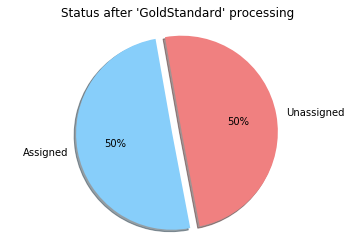

In [12]:
# -----------------
# Visualize results
# -----------------
''' CHANGE TO STACKED BAR; SHOW WHAT ASSIGNMENTS CAME FROM WHERE '''

# Pie for percentage of rows assigned; https://pythonspot.com/matplotlib-pie-chart/
totCount = len(logAfterGoldStandard)
unassigned = logAfterGoldStandard['SemanticGroup'].isnull().sum()
assigned = totCount - unassigned
labels = ['Assigned', 'Unassigned']
sizes = [assigned, unassigned]
colors = ['lightskyblue', 'lightcoral']
explode = (0.1, 0)  # explode 1st slice
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.f%%', shadow=True, startangle=100)
plt.axis('equal')
plt.title("Status after 'GoldStandard' processing")
plt.show()


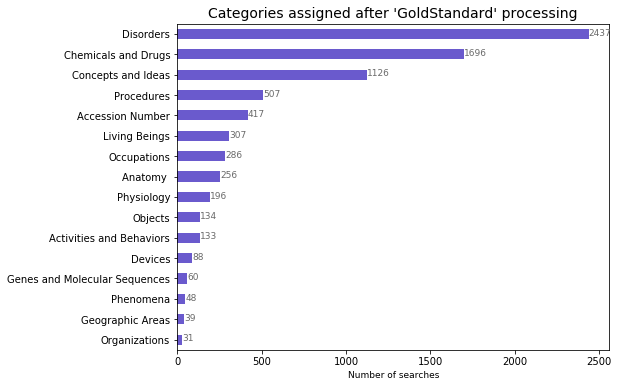

In [13]:
# Bar of SemanticGroup categories, horizontal
# Source: http://robertmitchellv.com/blog-bar-chart-annotations-pandas-mpl.html
ax = logAfterGoldStandard['SemanticGroup'].value_counts().plot(kind='barh', figsize=(10,6),
                                                 color="slateblue", fontsize=10);
ax.set_alpha(0.8)
ax.set_title("Categories assigned after 'GoldStandard' processing", fontsize=14)
ax.set_xlabel("Number of searches", fontsize=9);
# set individual bar lables using above list
for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_width()+.1, i.get_y()+.31, \
            str(round((i.get_width()), 2)), fontsize=9, color='dimgrey')
# invert for largest on top 
ax.invert_yaxis()
plt.gcf().subplots_adjust(left=0.3)

# Remove searchLogClean

# 8. Create 'uniques' dataframe/file for APIs


OPTIONS IF YOU DON'T WANT TO RUN THE ENTIRE LOG

Eyeball the df and select everything with 2 or more queries
listOfUniqueUnassignedAfterGS = listOfUniqueUnassignedAfterGS.iloc[0:11335]

Or, remove to a row count, such as to 186 based on looking at the content

listOfUniqueUnassignedAfterGS = listOfUniqueUnassignedAfterGS.iloc[186:]

listOfUniqueUnassignedAfterGS = listOfUniqueUnassignedAfterGS.reset_index()

If you think the count is too high you could reduce the allowed character count

mask = (listOfUniqueUnassignedAfterGS['adjustedQueryCase'].str.len() <= 15)

listOfUniqueUnassignedAfterGS = listOfUniqueUnassignedAfterGS.loc[mask]


In [14]:
# Re-starting?
# logAfterGoldStandard = pd.read_excel(localDir + 'logAfterGoldStandard.xlsx')

# Unique unassigned terms and frequency of occurrence
listOfUniqueUnassignedAfterGS = logAfterGoldStandard[pd.isnull(logAfterGoldStandard['preferredTerm'])] # was SemanticGroup
listOfUniqueUnassignedAfterGS = listOfUniqueUnassignedAfterGS.groupby('adjustedQueryCase').size()
listOfUniqueUnassignedAfterGS = pd.DataFrame({'timesSearched':listOfUniqueUnassignedAfterGS})
listOfUniqueUnassignedAfterGS = listOfUniqueUnassignedAfterGS.sort_values(by='timesSearched', ascending=False)
listOfUniqueUnassignedAfterGS = listOfUniqueUnassignedAfterGS.reset_index()

In [ ]:
# ---------------------------------------------------------------
# Eyeball for fixes - Don't give the API things it can't resolve
# ---------------------------------------------------------------

'''
*** RUN SOME OF THIS EVERY TIME - COMMENTED OUT TO AVOID DAMAGE ****

# Eyeball the data frame, sort by adjustedQueryCase; remove rows that as appropriate

# logAfterGoldStandard = logAfterGoldStandard.iloc[1595:] # remove before index...

listToCheck4 = listToCheck4[listToCheck4.adjustedQueryCase.str.contains("^[0-9]{4}") == False] # char entities
listToCheck4 = listToCheck4[listToCheck4.adjustedQueryCase.str.contains("^-") == False] # char entities
listToCheck4 = listToCheck4[listToCheck4.adjustedQueryCase.str.contains("^/") == False] # char entities
listToCheck4 = listToCheck4[listToCheck4.adjustedQueryCase.str.contains("^@") == False] # char entities
listToCheck4 = listToCheck4[listToCheck4.adjustedQueryCase.str.contains("^\[") == False] # char entities
listToCheck4 = listToCheck4[listToCheck4.adjustedQueryCase.str.contains("^;") == False] # char entities
listToCheck4 = listToCheck4[listToCheck4.adjustedQueryCase.str.contains("^<") == False] # char entities
listToCheck4 = listToCheck4[listToCheck4.adjustedQueryCase.str.contains("^>") == False] # char entities

listToCheck3.drop(58027, inplace=True)
'''

In [15]:
# Save to file so you can open in future sessions
writer = pd.ExcelWriter(localDir + 'listOfUniqueUnassignedAfterGS.xlsx')
listOfUniqueUnassignedAfterGS.to_excel(writer,'listOfUniqueUnassignedAfterGS')
# df2.to_excel(writer,'Sheet2')
writer.save()